In [1]:
# %%
# =================================================================================
# Cell 1: Setup and Environment Creation
# =================================================================================
# This cell installs necessary packages, creates a standard image-based
# environment, and defines a prompt_formatter for it.

# --- 1. Install Dependencies ---
# Note: You might need to restart the kernel after this installation.

import gymnasium as gym
from PIL import Image
import numpy as np
from typing import Any, Tuple, List, Dict

print("--- Dependencies Installed ---")

# --- 2. Create the Standard Environment ---
# CarRacing-v2 is a great choice because its observation is a standard
# (96, 96, 3) RGB image array, perfect for our LVLM.
env = gym.make("CarRacing-v2")
print("\n--- CarRacing-v2 Environment Created ---")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")
# The action space is continuous, but we will discretize it in the formatter.

# --- 3. Define the Corresponding Prompt Formatter ---
# This function is tailored specifically for the CarRacing-v2 environment.
def car_racing_formatter(obs: np.ndarray) -> Tuple[List[Dict], List[Image.Image]]:
    """
    A prompt formatter for the CarRacing-v2 environment.
    
    It discretizes the continuous action space and creates a detailed prompt.
    The continuous action space is Box(-1..1, (3,)), for steer, gas, brake.
    We will create 5 discrete actions:
    0: Steer Left
    1: Steer Right
    2: Gas
    3: Brake
    4: Straight (No action)
    """
    
    prompt_text = (
        "You are an expert driver in a race. Your goal is to drive the car "
        "around the track (grey road) as fast as possible without going off-road (green grass). The image "
        "is a birds eye view of your car, with the white number on the lower left being your speed in MPH.\n\n"
        "Choose one of the following discrete actions:\n"
        "[action id 1]: Steer left\n"
        "[action id 2]: Steer right\n"
        "[action id 3]: Accelerate\n"
        "[action id 0:] Coast (do nothing)\n\n"
        "if your speed is low <10MPH, choose id 3 to accelerate.\n"
        "however, if your speed is above 20MPH, prioritize steering to stay on the road by choosing id 1,0,or 2\n"
        "you MUST choose by selecting a single number corresponding to the desired action id, with NO extra formatting."
    )
    
    # The modern, correct chat format
    chat = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Analyze the racetrack from this image:"},
                {"type": "image"}, # Image placeholder
                {"type": "text", "text": prompt_text},
            ]
        }
    ]
    
    # The processor expects a list of PIL Images
    images = [Image.fromarray(obs)]
    
    return chat, images

print("\n--- `car_racing_formatter` Defined ---")

# --- 4. Test the Formatter with a Sample Observation ---
print("\n--- Testing the formatter with one sample... ---")
sample_obs, _ = env.reset()
sample_chat, sample_images = car_racing_formatter(sample_obs)

print("Formatter produced a chat structure:")
import json
print(json.dumps(sample_chat, indent=2))
print(f"\nFormatter produced {len(sample_images)} image(s).")
print(f"Image type: {type(sample_images[0])}, Image size: {sample_images[0].size}")

# Close the environment to free up resources
env.close()

print("\n--- Cell execution finished. You can now use `car_racing_formatter` ---")
print("--- and the environment name 'CarRacing-v2' to test the wrapper. ---")

--- Dependencies Installed ---

--- CarRacing-v2 Environment Created ---
Observation Space: Box(0, 255, (96, 96, 3), uint8)
Action Space: Box([-1.  0.  0.], 1.0, (3,), float32)

--- `car_racing_formatter` Defined ---

--- Testing the formatter with one sample... ---


/root/conda/envs/sb3/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Formatter produced a chat structure:
[
  {
    "role": "user",
    "content": [
      {
        "type": "text",
        "text": "Analyze the racetrack from this image:"
      },
      {
        "type": "image"
      },
      {
        "type": "text",
        "text": "You are an expert driver in a race. Your goal is to drive the car around the track (grey road) as fast as possible without going off-road (green grass). The image is a birds eye view of your car, with the white number on the lower left being your speed in MPH.\n\nChoose one of the following discrete actions:\n[action id 1]: Steer left\n[action id 2]: Steer right\n[action id 3]: Accelerate\n[action id 0:] Coast (do nothing)\n\nif your speed is low <10MPH, choose id 3 to accelerate.\nhowever, if your speed is above 20MPH, prioritize steering to stay on the road by choosing id 1,0,or 2\nyou MUST choose by selecting a single number corresponding to the desired action id, with NO extra formatting."
      }
    ]
  }
]

Formatte

In [4]:
# %%
# =================================================================================
# Cell 6: Advanced Environment with Frame Stacking via Prompt Formatting
# =================================================================================
# This cell defines a new, stateful prompt formatter that handles frame stacking
# internally, creating a history of captioned images for the LVLM.

import gymnasium as gym
from PIL import Image
import numpy as np
from typing import Any, Tuple, List, Dict
from collections import deque
from vlm_policies import LLMProcessingWrapper,LVLMActorCriticPolicy
from transformers import AutoProcessor
# --- Ensure previous components exist ---
MODEL_NAME='google/gemma-3-4b-it'
processor = AutoProcessor.from_pretrained(MODEL_NAME)
assert 'LLMProcessingWrapper' in locals(), "Please run the cell defining LLMProcessingWrapper."
assert 'processor' in locals(), "Please run a cell that defines the `processor`."

print("--- Defining Advanced Frame Stacking Formatter ---")

class FrameSkip(gym.Wrapper):
    """
    A wrapper that repeats the same action for a specified number of frames
    and returns the observation from the final frame.

    :param env: The environment to wrap.
    :param skip: The number of frames to skip for each action.
    """
    def __init__(self, env: gym.Env, skip: int = 4):
        super().__init__(env)
        if skip <= 0:
            raise ValueError("Frame skip must be a positive integer.")
        self.skip = skip

    def step(self, action):
        """
        Repeat the action `skip` times, returning the AVERAGE reward.
        """
        total_reward = 0.0
        steps_taken = 0
        
        for i in range(self.skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            steps_taken += 1
            
            # If the episode ends mid-skip, we must stop and return immediately
            if terminated or truncated:
                break
        
        # The crucial change: divide the total reward by the number of steps taken.
        average_reward = total_reward / steps_taken
        
        return obs, average_reward, terminated, truncated, info

    def reset(self, **kwargs):
        """Resets the environment."""
        return self.env.reset(**kwargs)
    

# --- 5. Create the Final, Fully-Equipped Environment ---
print("\n--- Creating the final, wrapped environment with frame stacking... ---")

# a. Create the base environment
base_env = gym.make("CarRacing-v2",render_mode="rgb_array",continuous=False)
base_env = FrameSkip(base_env,skip=7)
# b. Apply the action discretizer
# discretized_env = DiscretizedCarRacing(base_env)

# c. Apply the LLM Processing wrapper with our new stateful formatter
env = LLMProcessingWrapper(
    base_env,
    processor=processor, 
    prompt_formatter=car_racing_formatter, # Use the new formatter object
    max_length=480, # Increase max_length for the larger prompt
)

print("\n--- Environment `env` is now ready for your manual rollout cell! ---")
print("It provides a history of 4 images in the prompt at each step.")

# --- Quick Test ---
print("\n--- Testing one step of the new environment... ---")
obs, _ = env.reset()
print(obs['input_ids'])
print("Observation received. Keys:", obs.keys())
print("Shape of 'input_ids':", obs['input_ids'].shape) # Should have a larger sequence length
# env.close()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


--- Defining Advanced Frame Stacking Formatter ---

--- Creating the final, wrapped environment with frame stacking... ---
[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 480), dtype=int64
  - Detected space 'attention_mask': shape=(1, 480), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 480), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=float32

--- Environment `env` is now ready for your manual rollout cell! ---
It provides a history of 4 images in the prompt at each step.

--- Testing one step of the new environment... ---
[[     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      2      2    105   2364    107 115863    506 216150
     699    672   2471 236787    108 255999 262144 262144 262144 262144
  262144 262144 262144 262144 262144 262144 262144 262144 262144 26214

In [ ]:
# %%
# =================================================================================
# Cell 7: End-to-End PPO Training Test
# =================================================================================
# This cell instantiates the SB3 PPO agent with our custom components
# and launches the training loop.
%load_ext autoreload
%autoreload 2
import torch
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# --- 1. Ensure Environment and Policy are Ready ---
assert 'env' in locals(), "Please run the previous cell to create the `env` object."
# assert 'policy' in locals(), "Please run the cell that instantiates the `policy` object."

# Since the policy is already instantiated, we don't need to pass `policy_kwargs`.
# We pass the instantiated policy object directly.
# However, the action space of the policy must match the environment's. Let's verify.
# assert policy.action_space == env.action_space, \
#     f"Action space mismatch! Policy has {policy.action_space} but Env has {env.action_space}"
# --- 2. Create the Vectorized Environment ---
N_ENVS = 4 # Number of parallel environments. 8 is a good starting point.
base_env_id = "CarRacing-v2"

# We use a partial function to pass arguments to our custom wrapper.
# This ensures each of the 8 parallel environments is correctly wrapped.
wrapper_kwargs = {
    'processor': processor,
    'prompt_formatter': car_racing_formatter,
    'max_length': 480
}
# We also apply the FrameSkip wrapper to each environment
env_kwargs = {'continuous': False}

# Use SB3's make_vec_env to handle the creation of parallel processes
vec_env = make_vec_env(
    base_env_id,
    n_envs=N_ENVS,
    env_kwargs=env_kwargs,
    # This is a bit complex: we want to wrap with FrameSkip THEN LLMProcessingWrapper
    # A cleaner way is to define a single function that does the wrapping.
    wrapper_class=lambda env: LLMProcessingWrapper(FrameSkip(env, skip=5), **wrapper_kwargs)
)

print(f"\n--- VecEnv created with {vec_env.num_envs} parallel environments. ---")
print("--- All components are ready. Preparing PPO agent... ---")

# --- 2. Configuration for the PPO Agent ---
# For a complex model like an LVLM, we need a large rollout buffer to get
# stable gradients. We also want to keep it on the CPU to save VRAM.
N_STEPS = 60       # Number of steps to collect per rollout
BATCH_SIZE = 2     # Mini-batch size for each gradient update
N_EPOCHS = 2        # How many times to loop over the collected data
LEARNING_RATE = 1e-6 # A smaller learning rate is often better for fine-tuning
torch.cuda.empty_cache()
# --- 3. Instantiate the PPO Agent ---
# We use the standard PPO class from Stable Baselines 3.
# The magic is in passing our custom, pre-instantiated policy object.
model = PPO(
    policy=LVLMActorCriticPolicy,
    env=env,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    learning_rate=LEARNING_RATE,
    verbose=1,
    tensorboard_log="./ppo_lvlm_car_racing_tensorboard/",
    policy_kwargs={"device":"cuda:1"},
    clip_range_vf=0.2, # Clip the value function update
    clip_range=0.2,    # Standard clipping for the policy
    max_grad_norm=1,
    normalize_advantage=True,
    ent_coef=0.1,
    gamma=0.94,
    device='cuda:1'
    # learning_rate=5e-6,
    # verbose=1
)

print("\n--- PPO Agent Instantiated Successfully! ---")
print(f"Policy Class: {type(model.policy)}")
print(f"Rollout buffer size: {model.n_steps} steps")
print(f"Device: {model.device}")


# --- 4. Start the Training Loop ---
# This is the final step. The `learn()` method will now orchestrate the
# entire process: collecting rollouts by calling `env.step()`, and then
# training the policy by calling its `evaluate_actions()` method.
print("\n==================================================")
print("             STARTING PPO TRAINING              ")
print("==================================================")
try:
    # Let's train for a set number of timesteps to see if it works
    model.learn(total_timesteps=20000)
    
    print("\n==================================================")
    print("           TRAINING COMPLETED SUCCESSFULLY        ")
    print("==================================================")

    # Save the final model for later use
    model.save("ppo_lvlm_car_racing")
    print("\nModel saved to ppo_lvlm_car_racing.zip")

except Exception as e:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("             TRAINING FAILED!                     ")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("Error:", e)
    import traceback
    traceback.print_exc()

finally:
    # It's crucial to close the environment to shut down renderers etc.
    env.close()

[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 480), dtype=int64
  - Detected space 'attention_mask': shape=(1, 480), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 480), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=float32
[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 480), dtype=int64
  - Detected space 'attention_mask': shape=(1, 480), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 480), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=float32
[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 480), dtype=int64
  - Detected space 'attention_mask': shape=(1, 480), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 480), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=flo

/root/conda/envs/sb3/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:78: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


Using cuda:1 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LoRA enabled. Trainable parameters:
trainable params: 131,153,920 || all params: 4,431,233,392 || trainable%: 2.9598

--- PPO Agent Instantiated Successfully! ---
Policy Class: <class 'vlm_policies.LVLMActorCriticPolicy'>
Rollout buffer size: 60 steps
Device: cuda:1

             STARTING PPO TRAINING              
Logging to ./ppo_lvlm_car_racing_tensorboard/PPO_20
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51       |
|    ep_rew_mean     | -15.2    |
| time/              |          |
|    fps             | 3        |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 60       |
---------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 45       |
|    ep_rew_mean          | -45.7    |
| time/                   |          |
|    fps                  | 1        |
|    iterations           | 2        |
|    time_elapsed 

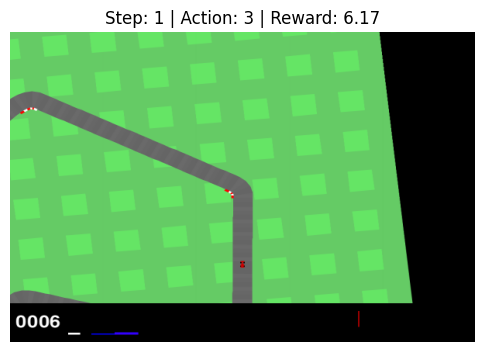

stepping


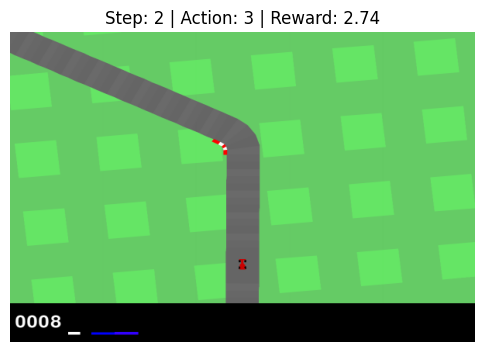

stepping


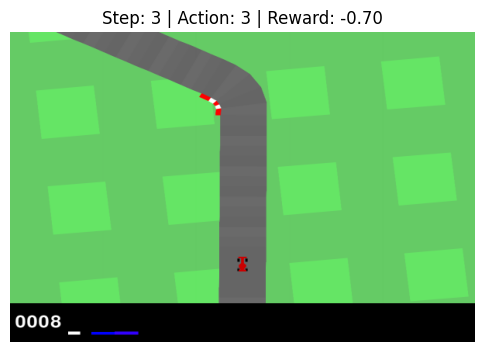

stepping


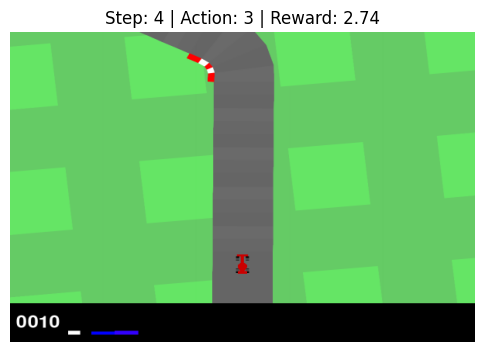

stepping


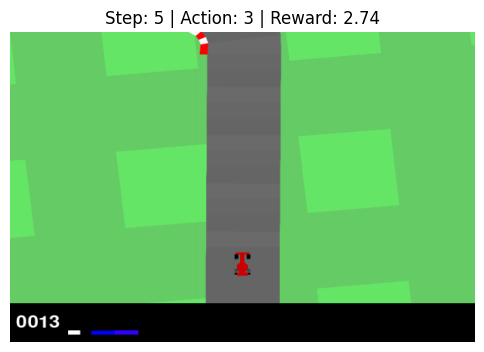

stepping


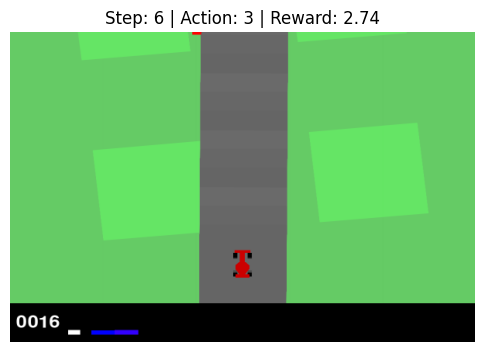

stepping


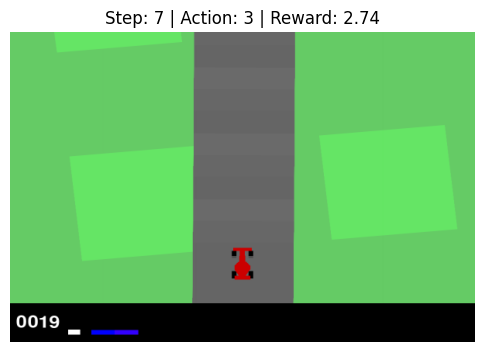

stepping


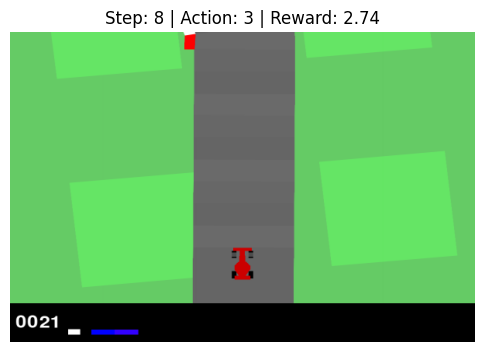

stepping


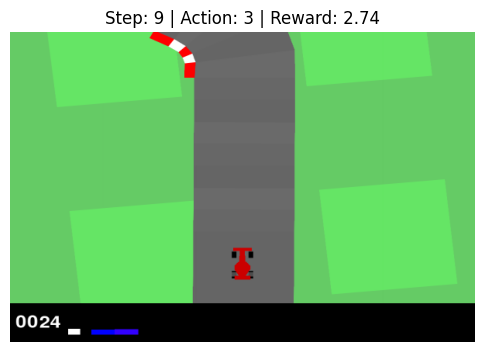

stepping


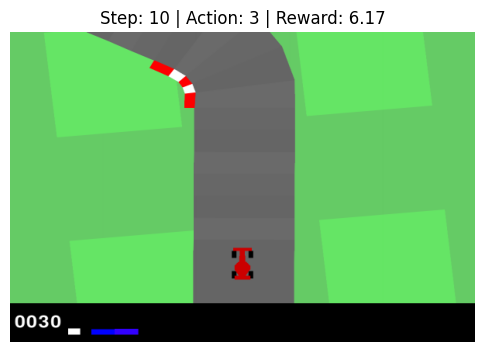

stepping


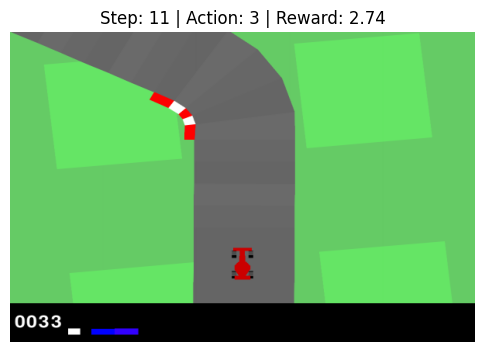

stepping


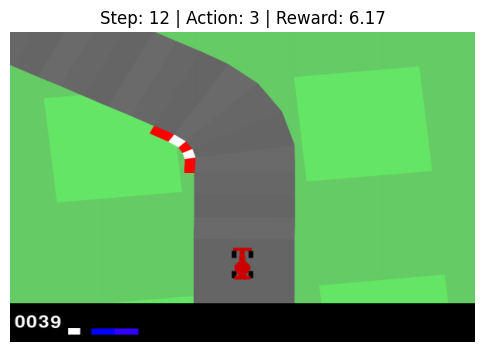

stepping


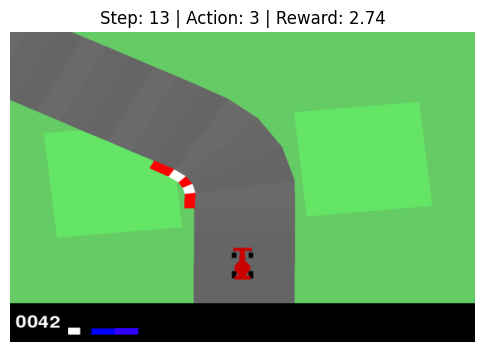

stepping


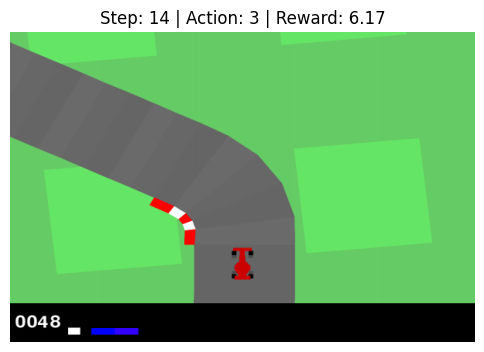

stepping


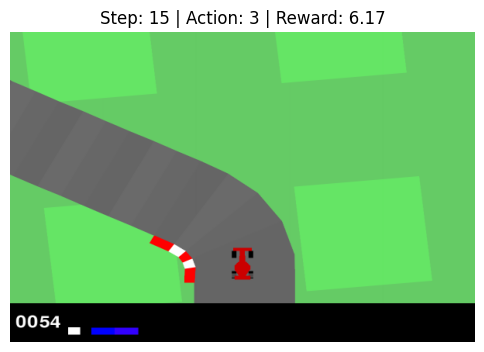

stepping


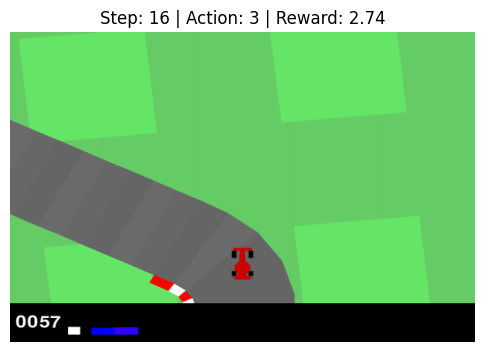

stepping


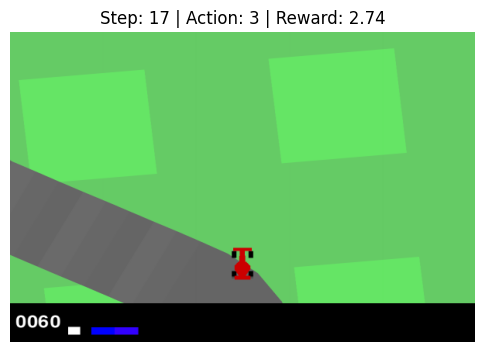

stepping


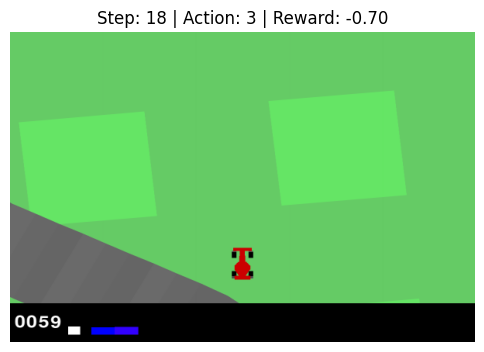

stepping


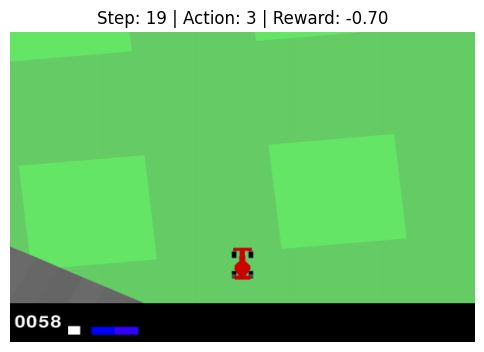

stepping


KeyboardInterrupt: 

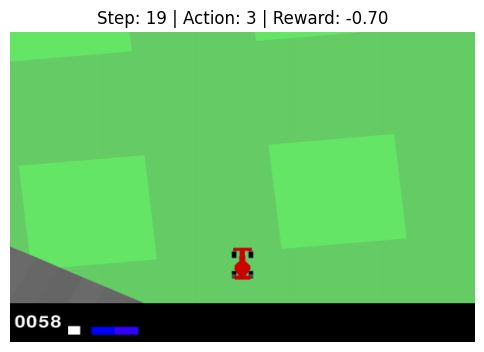

In [4]:
import matplotlib.pyplot as plt
import time
# env = LLMProcessingWrapper(
#     gym.make("CarRacing-v3", render_mode="rgb_array"), # Use "rgb_array" for rendering
#     processor=processor, 
#     prompt_formatter=car_racing_formatter,
#     max_length=512
# )
# Reset the environment to get the first observation
raw_obs, info = env.reset() # This is the processed observation dict

# Setup for visualization
fig, ax = plt.subplots(figsize=(6, 6))
# img_display = ax.imshow(env.env.render())
ax.axis('off')

# Rollout loop
terminated = False
truncated = False
total_reward = 0
episode_length = 0

while not (terminated or truncated):
    # --- A. Prepare the Observation for the Policy ---
    # The observation from the wrapper is a dict of NumPy arrays.
    # We need to manually add a batch dimension and move it to the GPU.
    obs_tensor = {
        key: torch.as_tensor(value).unsqueeze(0).to(policy.device) 
        for key, value in raw_obs.items()
    }

    # --- B. Get Action from the Policy ---
    with torch.no_grad():
        # We use deterministic=True for evaluation to see the policy's "best guess"
        # obs_tensor['pixel_values']=obs_tensor['pixel_values'].squeeze()
        actions, values, log_probs = policy.forward(obs_tensor, deterministic=False)
        # Get Action AND the full distribution from the Policy
    # # with torch.no_grad():
    # #     # Get the distribution object by calling the internal method
    # #     latent_pi, _, _ = policy._get_latent(obs_tensor)
    # #     distribution = policy._get_action_dist_from_latent(latent_pi)
        
    # #     # Get the probabilities and the sampled action
    # #     probs = distribution.get_probs().cpu().numpy()[0]
    # #     action_to_take = distribution.get_actions(deterministic=False).cpu().numpy()[0]
    # # The action is a tensor, get the NumPy value to pass to the env
    action_to_take = actions.cpu().numpy()[0]
    # action_to_take=3
    # --- C. Discretize the CarRacing Action ---
    # The formatter prompt defines our discrete action mapping. We must replicate it here.
    # [steer, gas, brake]
    # action_map = {
    #     0: [-1.0, 0.0, 0.0],  # Steer Left
    #     1: [ 1.0, 0.0, 0.0],  # Steer Right
    #     2: [ 0.0, 1.0, 0.0],  # Gas
    #     3: [ 0.0, 0.0, 0.8],  # Brake
    #     4: [ 0.0, 0.0, 0.0],  # Straight
    # }
    # continuous_action = np.array(action_map[action_to_take])
    # print(f"Action Probabilities: [L: {probs[0]:.2f}, R: {probs[1]:.2f}, Gas: {probs[2]:.2f}, Brk: {probs[3]:.2f}, Str: {probs[4]:.2f}]")
    # --- D. Step the Environment ---
    # The wrapper's step function will automatically process the next observation
    raw_obs, reward, terminated, truncated, info = env.step(action_to_take)
    
    total_reward += reward
    episode_length += 1

    # --- E. Visualize and Print Info ---
    # Update the plot with the new frame
    # img_display.set_data(env.render())
    ax.imshow(env.env.render())
    ax.set_title(f"Step: {episode_length} | Action: {action_to_take} | Reward: {reward:.2f}")
    display(fig)
    # clear_output(wait=True)
    print("stepping")
    # time.sleep(0.05) # Small delay to make it watchable

print("\n--- Rollout Finished! ---")
print(f"Total Reward: {total_reward:.2f}")
print(f"Episode Length: {episode_length}")
print(f"Termination Reason: {'Terminated' if terminated else 'Truncated'}")

# Clean up
plt.close(fig)